In [1]:
from pyspark import SparkContext
from pyspark.sql import Row, SQLContext, SparkSession
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sc = SparkContext()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 10:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark = SparkSession(sc)

In [7]:
file_path = os.path.join('..', 'src-data', '2017_StPaul_MN_Real_Estate.csv')
df = spark.read.csv(file_path, header = True, inferSchema = True)
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: integer (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullable = 

In [14]:
df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET', 'YEARBUILT')

### Data cleaning

#### 1. Delete some irrevalent feature
use `drop` method

In [15]:
# number of coluumn
print(f"number of columns: {len(df_sub.columns)}")

number of columns: 10


In [16]:
print(f"number of column after drop: {len(df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']).columns)}")

number of column after drop: 8


#### 2. Text filter
- `where(condtion)`
- `filter(condition)`
- `like()`
- `~`

In [20]:
df_sub.select('ASSUMABLEMORTGAGE').distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



remove or contain row with contain 'Yes w/ Qualifying', 'Yes w/No Qualifying' and null value.

Use `~` and  `.isin(list)`

In [21]:
lst = ['Yes w/ Qualifying', 'Yes w/No Qualifying|']
text_filter_1 = df_sub["ASSUMABLEMORTGAGE"].isin(lst)

In [23]:
df_sub_filter_1 = df_sub.where(text_filter_1)
df_sub_filter_1.count()

21

In [24]:
df_sub_filter_1.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|YEARBUILT|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+
|               6044|         0|           80x150|Exclusive Right|0.276|Yes w/ Qualifying|         215000|   210000|          18|     1955|
|               1019|         0|           30x102|Exclusive Right| 0.07|Yes w/ Qualifying|         175000|   165000|           3|     1912|
|               2049|         0|           Common|Exclusive Right|  0.0|Yes w/ Qualifying|         174000|   174900|          60|     1949|
|                989|         0|           40x122|Exclusive Right| 0.11|Yes w/ Qualifying|         178400|   175000|          21|     1920|
|               1892

In [35]:
text_filter_2 = ~ (df_sub["ASSUMABLEMORTGAGE"].isin(lst)) | df_sub["ASSUMABLEMORTGAGE"].isNull()

In [36]:
df_sub_filter_2 = df_sub.where(text_filter_2)
df_sub_filter_2.count()

4979

In [37]:
df_sub_filter_2.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|YEARBUILT|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|     1950|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|     1971|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|     1949|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|     1960|
|               2915

#### 3. Remove outliers according to Gaussian distribution

req: remove outlier in 'SalesClosePrice'

In [43]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

**first step**: apply some function to convert Gaussian distribution. read [here](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

In that case the 'SalesClosePrice' is right skewed distribution, so apply `log scale` method.

In [40]:
df_sub = df_sub.withColumn("log_SalesClosePrice", F.log(F.col("SalesClosePrice")))

In [45]:
df_pandas = df_sub.toPandas()

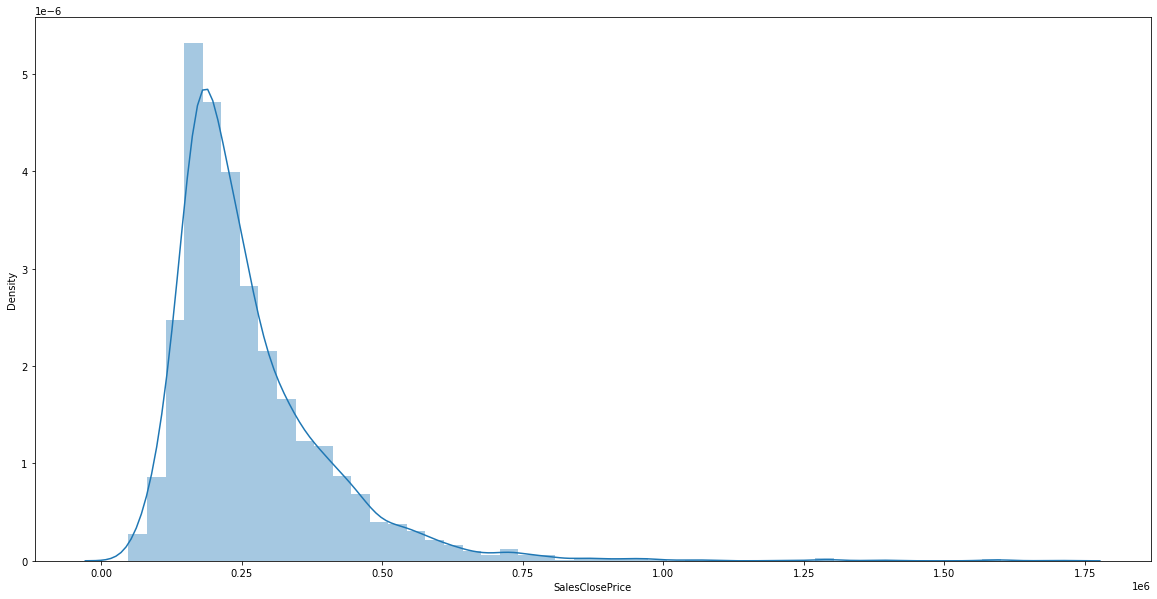

In [46]:
plt.figure(figsize = (20,10))
sns.distplot(df_pandas.SalesClosePrice)
plt.show()

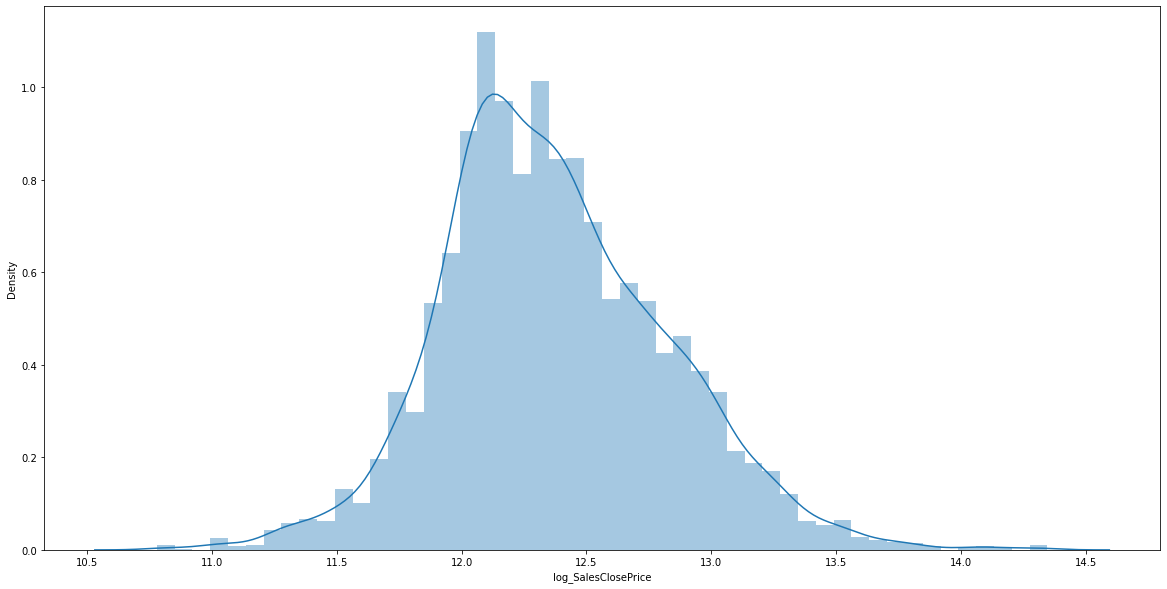

In [47]:
plt.figure(figsize = (20,10))
sns.distplot(df_pandas.log_SalesClosePrice)
plt.show()

**Second step**: calculate the high bound and low bound in boxplot

mean value

In [48]:
df_sub.agg({'log_SalesClosePrice': "mean"}).collect()

[Row(avg(log_SalesClosePrice)=12.369716258093085)]

In [49]:
# get value 
df_sub.agg({'log_SalesClosePrice': "mean"}).collect()[0][0]

12.369716258093085

In [50]:
mean_val = df_sub.agg({'log_SalesClosePrice': "mean"}).collect()[0][0]

std value

In [51]:
std_value = df_sub.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

low bound = mean - 3 * std

high bound = mean + 3 * std

In [53]:
low_bound = mean_val - (3 * std_value)
hi_bound = mean_val + (3 * std_value)

remove all values which are greater than high bound and smaller tahn low bound.

In [54]:
print(f'Number row before: {df_sub.count()}')

Number row before: 5000


In [55]:
df_sub = df_sub.where((df_sub["log_SalesClosePrice"] < hi_bound)& 
                     (df_sub["log_SalesClosePrice"] > low_bound))

In [56]:
print(f'Number row after: {df_sub.count()}')

Number row after: 4968


#### 4. Remove data according to NA, NULL

use `dropna` method. Read [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.dropna.html)

In [65]:
df_sub.count()

4968

In [64]:
df_sub.dropna().count()

1886

In [66]:
df_sub.dropna(thresh=1).count()

4968

#### 4. Remove data according to duplication

use `drop_duplicates`

In [68]:
df_sub.drop_duplicates().count() # mean don't have duplication

4968

#### 5. Min-Max Scaling

![plot](http://androidkt.com/wp-content/uploads/2020/10/Selection_060.png)

In [69]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_values) / (max_values - min_values))
    return df

In [73]:
df_new = min_max_scaler(df_sub, ['SalesClosePrice', 'ACRES'])

In [74]:
df_new.show(2)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+----------------------+------------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|YEARBUILT|log_SalesClosePrice|scaled_SalesClosePrice|      scaled_ACRES|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+----------------------+------------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|     1950| 11.870599909242044|    0.0971563981042654|0.1351636747624076|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|     1971| 12.154779351142624|    0.1528436018957346|0.03379091

#### 6. Standard Scaling

![plot](https://miro.medium.com/max/660/1*qXXqcZXhSTgw9tVhx7zNNw.gif)

In [75]:
def standard_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        mean_val = df_sub.agg({"SalesClosePrice": "mean"}).collect()[0][0]
        stddev_val = df_sub.agg({"SalesClosePrice": "stddev"}).collect()[0][0]
        new_column_name = 'Standard' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - mean_val) / (stddev_val))
    return df

In [76]:
df_new = standard_scaler(df_sub, ['SalesClosePrice', 'ACRES'])

In [77]:
df_new.show(2)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+-----------------------+-------------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|YEARBUILT|log_SalesClosePrice|StandardSalesClosePrice|      StandardACRES|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+-----------------------+-------------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|     1950| 11.870599909242044|    -0.9317590876349842|-2.0833537742199817|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|     1971| 12.154779351142624|     -0.553259543936307| 

#### 7. Log scaling

In [78]:
df_new = df_sub.withColumn("log_SalesClosePrice", F.log(F.col("SalesClosePrice")))

In [79]:
df_new.show(2)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|YEARBUILT|log_SalesClosePrice|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|     1950| 11.870599909242044|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|     1971| 12.154779351142624|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+---------+-------------------+
only showing top 2 rows



#### 8. Missing data

count missing data

In [82]:
# count missing rows
df.where(df["ASSUMABLEMORTGAGE"].isNull()).count()

3104

In [83]:
df.count()

5000

In [85]:
rate_missing = round(df.where(df["ASSUMABLEMORTGAGE"].isNull()).count() / df.count(), 3)
rate_missing

0.621

Remove missing data when:
- Rate of missing data is small.
- Randomly missing

In [86]:
# drop column with more than threshold percentage with missing value
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. 
    # Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [87]:
df_new = column_dropper(df, 0.5)

In [90]:
print(f'Number dropped columns: {len(df.columns) - len(df_new.columns)}')

Number dropped columns: 6
